In [5]:
##########################################################複製區塊
# import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np

#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000
frq_min = 0
frq_max = 1.25*25/(6*np.pi)
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
dfp = 1/2
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp=1
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*22)
resolution = 10
sz = 16  
cell = mp.Vector3(0, 0, sz)
dpml = 1.0
pml_layers = [mp.PML(dpml)]
nq = 0


for i in range(Ncomp):
    
    #generate random numbers
    M0 = np.random.normal(0,1)
    Mlp = np.random.normal(0,1,M-1)
    Nlp = np.random.normal(0,1,M-1)
    MM = np.random.normal(0,1)
    
    #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
    #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
    #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
    Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
    Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
    Eflm = np.flip(np.conjugate(Eflp))
    EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
    Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
    #we normalize Ef and compute its inverse fast fourier transform
    Efn = deltap*T/np.sqrt(tsim)*Ef
    En = np.fft.ifft(Efn)
    
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('m'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    def source(t):
        f = int(t*200)
        print(t)
        #print(f)
        return En[f]

    sources = [mp.Source(mp.CustomSource(src_func=source),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     #amplitude=2e-9
                     )]
    
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution)
    

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,-0.5*sz+dpml+0.5))#, size=mp.Vector3(0,2,0))
    tran = sim.add_flux(fcen, df*dfp, nfreq, tran_fr)
    
    
    sim.run(until=1)

    tran_flux = mp.get_fluxes(tran)
    flux_freqs = mp.get_flux_freqs(tran)
    Ts = []
    fs = []
    for i in range(nfreq):
        fs = np.append(fs,flux_freqs[i])
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it
######################################################複製區塊


[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 5.10216e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 10
time for set_epsilon = 0.000157118 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1.0)

0.0
0.0
0.05
0.05
0.1
0.1
0.15000000000000002
0.15000000000000002
0.2
0.2
0.25
0.25
0.30000000000000004
0.30000000000000004
0.35000000000000003
0.35000000000000003
0.4
0.4
0.45
0.45
0.5
0.5
0.55
0.55
0.6
0.6
0.6000000000000001
0.6000000000000001
0.6500000000000001
0.6500000000000001
0.7000000000000001
0.7000000000000001
0.7500000000000001
0.7500000000000001
0.8
0.8
0.8500000000000001
0.8500000000000001
0.9
0.9
0.9500000000000001
0.9500000000000001
1.0
1.0
run 0 finished at t = 1.0 (10 timesteps)


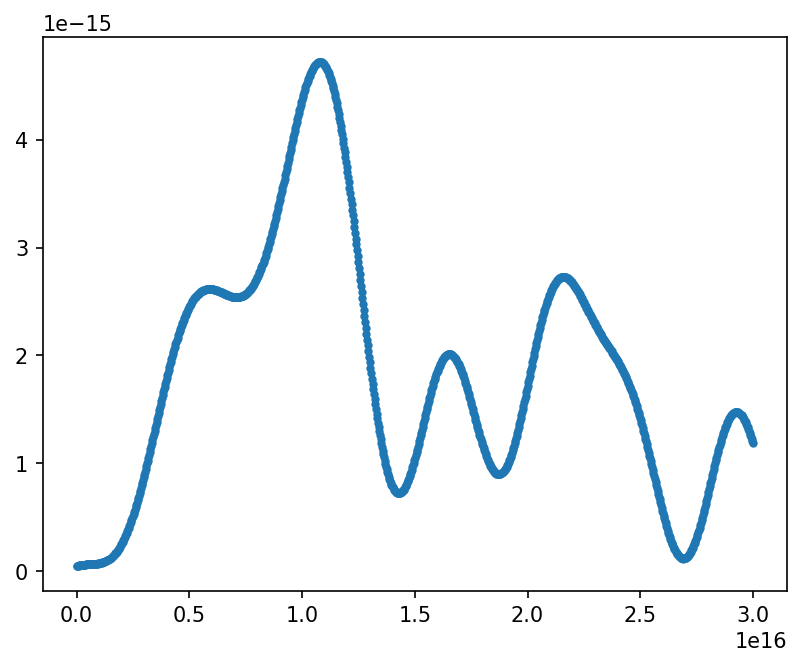

In [2]:
plt.figure(dpi=150)
freqs = np.linspace(0,30e15,1000)
plt.plot(freqs,Efavg,'.')
#plt.xlim(0,25e15)
#plt.ylim(0,1e-12)
plt.savefig('detector_vacuum_300001.png')
plt.show()

#np.savez("custom_source_vacuum_30000.npz", Efavg_30000 = Efavg)

In [37]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('detector_vacuum_300001.png','trans_detector_vacuum_300001.png')